# Prepare

## Block 1: Imports and Global Config

In [ ]:
import numpy as np
import pickle
import os
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import StratifiedKFold as skf
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import MinMaxScaler, label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

torch.manual_seed(42)
np.random.seed(42)

# Global hyperparameters
global_params = {
    "k_folds": 5,
    "batch_size": 16,
    "num_epochs": 100,
    "hidden_dim": 64,
    "wavelet_types": ['dog','mexican_hat','morlet','meyer','shannon'],
    "degree": 3,
    "grid_size": 5,
    "learning_rate": 1e-3,
}

Using device: cuda


## Block 2: Data Loading and Preprocessing

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Not in Colab or drive mount not needed.")

eeg_file_dir = '/content/drive/MyDrive/EEG_DE_features/'
eye_movement_file_dir = '/content/drive/MyDrive/Eye_movement_features/'

def pad_data(data, target_shape):
    pad_width = [
        (0, target_shape[i] - data.shape[i]) if i < len(data.shape)
        else (0, target_shape[i]) for i in range(len(target_shape))
    ]
    return np.pad(data, pad_width, mode='constant')

all_data = []
all_eye_data = []
all_labels = []
subjects = []

for i in range(1, 17):
    eeg_file_path = os.path.join(eeg_file_dir, f'{i}_123.npz')
    eye_file_path = os.path.join(eye_movement_file_dir, f'{i}_123.npz')

    eeg_npz = np.load(eeg_file_path, allow_pickle=True)
    eeg_data = pickle.loads(eeg_npz['data'])
    eeg_label = pickle.loads(eeg_npz['label'])

    eye_npz = np.load(eye_file_path, allow_pickle=True)
    eye_data = pickle.loads(eye_npz['data'])

    for key in eeg_data.keys():
        all_data.append(eeg_data[key])
        all_eye_data.append(eye_data[key])
        all_labels.append(eeg_label[key][0])
        subjects.append(i)

max_eeg_shape = np.max([d.shape for d in all_data], axis=0)
max_eye_shape = np.max([d.shape for d in all_eye_data], axis=0)

all_data_padded     = [pad_data(d, max_eeg_shape) for d in all_data]
all_eye_data_padded = [pad_data(d, max_eye_shape) for d in all_eye_data]

eeg_data_array = np.array(all_data_padded)
eye_data_array = np.array(all_eye_data_padded)
labels_array   = np.array(all_labels)

print("EEG data shape:", eeg_data_array.shape)
print("Eye data shape:", eye_data_array.shape)
print("Labels shape:  ", labels_array.shape)

eeg_data_flat = eeg_data_array.reshape(eeg_data_array.shape[0], -1)
eye_data_flat = eye_data_array.reshape(eye_data_array.shape[0], -1)

scaler_eeg = MinMaxScaler()
scaler_eye = MinMaxScaler()

eeg_data_flat = scaler_eeg.fit_transform(eeg_data_flat)
eye_data_flat = scaler_eye.fit_transform(eye_data_flat)

labels_array = labels_array.astype(int)

num_classes = len(np.unique(labels_array))
class_names = [f"Class {i}" for i in range(num_classes)]
print("Class names:", class_names)
print("Number of classes:", num_classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EEG data shape: (720, 74, 310)
Eye data shape: (720, 74, 33)
Labels shape:   (720,)
Class names: ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
Number of classes: 5


## Block 3: Helper Functions

In [ ]:
def compute_average_metrics(metrics_dict):
    avg = {}
    avg['accuracy']   = np.mean(metrics_dict['accuracy'])
    avg['precision']  = np.mean(metrics_dict['precision'])
    avg['recall']     = np.mean(metrics_dict['recall'])
    avg['f1']         = np.mean(metrics_dict['f1'])
    avg['auc']        = np.nanmean(metrics_dict['auc'])
    avg['confusion_matrix'] = metrics_dict['confusion_matrix']
    avg['num_parameters']   = metrics_dict['num_parameters']
    return avg

def plot_confusion_matrix(cm, classes, model_name="Model"):
    plt.figure(figsize=(6,4))
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

## Block 4: Training/Evaluation Template

In [ ]:
def train_and_evaluate_with_losses(model,
                                   train_loader,
                                   test_loader,
                                   epochs,
                                   lr,
                                   device,
                                   metrics_dict,
                                   n_classes):
    """
    A modified training/evaluation function that also returns
    epoch-by-epoch training & validation losses.
    """
    if metrics_dict['num_parameters'] is None:
        metrics_dict['num_parameters'] = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_accuracy = 0.0
    best_metrics  = None

    train_losses = []
    val_losses   = []

    for ep in range(epochs):
        # --------------------- TRAINING ---------------------
        model.train()
        total_loss = 0.0
        total_correct = 0

        for eeg_batch, eye_batch, labels_batch in train_loader:
            eeg_batch    = eeg_batch.to(device)
            eye_batch    = eye_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(eeg_batch, eye_batch)
            loss    = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss    += loss.item() * labels_batch.size(0)
            _, predicted   = torch.max(outputs, dim=1)
            total_correct += (predicted == labels_batch).sum().item()

        epoch_train_loss = total_loss / len(train_loader.dataset)
        epoch_train_acc  = total_correct / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ------------------- VALIDATION ---------------------
        model.eval()
        val_total_loss = 0.0
        val_correct    = 0
        all_labels     = []
        all_preds      = []
        all_probs      = []

        with torch.no_grad():
            for eeg_val, eye_val, labels_val in test_loader:
                eeg_val    = eeg_val.to(device)
                eye_val    = eye_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(eeg_val, eye_val)
                val_loss    = criterion(outputs_val, labels_val)
                val_total_loss += val_loss.item() * labels_val.size(0)

                _, val_pred   = torch.max(outputs_val, dim=1)
                val_correct  += (val_pred == labels_val).sum().item()

                all_labels.extend(labels_val.cpu().numpy())
                all_preds.extend(val_pred.cpu().numpy())
                probs = torch.softmax(outputs_val, dim=1)
                all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_total_loss / len(test_loader.dataset)
        epoch_val_acc  = val_correct / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Compute additional metrics
        f1_val   = f1_score(all_labels, all_preds, average='macro')
        prec_val = precision_score(all_labels, all_preds, average='macro')
        rec_val  = recall_score(all_labels, all_preds, average='macro')

        labels_bin = label_binarize(all_labels, classes=range(n_classes))
        try:
            auc_val = roc_auc_score(labels_bin, np.array(all_probs),
                                    average='macro', multi_class='ovr')
        except ValueError:
            auc_val = float('nan')

        cm = confusion_matrix(all_labels, all_preds)

        # Track best accuracy
        if epoch_val_acc > best_accuracy:
            best_accuracy = epoch_val_acc
            best_metrics  = {
                'accuracy':   best_accuracy,
                'precision':  prec_val,
                'recall':     rec_val,
                'f1':         f1_val,
                'auc':        auc_val,
                'confusion_matrix': cm
            }

        print(f"Epoch [{ep+1}/{epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | "
              f"Val Acc: {epoch_val_acc:.4f} | "
              f"F1: {f1_val:.4f}")

    # Save best metrics in metrics_dict
    metrics_dict['accuracy'].append(best_metrics['accuracy'])
    metrics_dict['precision'].append(best_metrics['precision'])
    metrics_dict['recall'].append(best_metrics['recall'])
    metrics_dict['f1'].append(best_metrics['f1'])
    metrics_dict['auc'].append(best_metrics['auc'])
    metrics_dict['confusion_matrix'] += best_metrics['confusion_matrix']

    # Return the recorded loss curves
    return train_losses, val_losses

all_loss_curves = {
    #"MLP": {
    #    "train": [],
    #    "val": []
    #},
    "Wavelet KAN (dog)": {
        "train": [],
        "val": []
    },
    "Wavelet KAN (morlet)": {
        "train": [],
        "val": []
    },
    "Wavelet KAN (mexican_hat)": {
        "train": [],
        "val": []
    },
    "Wavelet KAN (meyer)": {
        "train": [],
        "val": []
    },
    #"Wavelet KAN (shannon)": {
    #    "train": [],
    #    "val": []
    #},

    # ...
    "Efficient KAN": {
        "train": [],
        "val": []
    },
    "Jacobi-KAN": {
        "train": [],
        "val": []
    },
    "Chebyshev-KAN": {
        "train": [],
        "val": []
    },
    "Fourier-KAN": {
        "train": [],
        "val": []
    },
    "Hermite-KAN": {
        "train": [],
        "val": []
    },
    "RBF-KAN": {
        "train": [],
        "val": []
    }
}

# Models

## Block 5: MLP Model

In [ ]:
class MLPDecisionFusion(nn.Module):
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim, num_classes):
        super(MLPDecisionFusion, self).__init__()
        self.eeg_branch = nn.Sequential(
            nn.Linear(eeg_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.eye_branch = nn.Sequential(
            nn.Linear(eye_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, eeg_input, eye_input):
        x_eeg = self.eeg_branch(eeg_input)
        x_eye = self.eye_branch(eye_input)
        combined = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(combined)

## Block 6: Wavelet KAN Model

In [ ]:
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type

        self.scale       = nn.Parameter(torch.ones(out_features, in_features))
        self.translation = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_base     = nn.Parameter(torch.Tensor(out_features, in_features))
        self.wavelet_weights = nn.Parameter(torch.Tensor(out_features, in_features))

        nn.init.kaiming_uniform_(self.weight_base,    a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.wavelet_weights, a=math.sqrt(5))

        self.base_activation = nn.SiLU()
        self.bn = nn.BatchNorm1d(out_features)

    def wavelet_transform(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        tr_exp = self.translation.unsqueeze(0).expand(x.size(0), -1, -1)
        sc_exp = self.scale.unsqueeze(0).expand(x.size(0), -1, -1)
        x_scaled = (x - tr_exp) / (sc_exp + 1e-6)

        # Implementation of different wavelet types
        if self.wavelet_type == 'mexican_hat':
            term1 = (x_scaled ** 2) - 1
            term2 = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = (2 / (math.sqrt(3) * math.pi**0.25)) * term1 * term2
        elif self.wavelet_type == 'morlet':
            omega0 = 5.0  # Central frequency
            real = torch.cos(omega0 * x_scaled)
            envelope = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = envelope * real
        elif self.wavelet_type == 'dog':
            # Derivative of Gaussian Wavelet
            wavelet = -x_scaled * torch.exp(-0.5 * x_scaled ** 2)
        elif self.wavelet_type == 'meyer':
            # Meyer Wavelet
            v = torch.abs(x_scaled)
            pi = math.pi

            def meyer_aux(v):
                return torch.where(
                    v <= 0.5,
                    torch.ones_like(v),
                    torch.where(
                        v >= 1.0,
                        torch.zeros_like(v),
                        torch.cos(pi / 2 * nu(2 * v - 1))
                    )
                )

            def nu(t):
                return t**4 * (35 - 84 * t + 70 * t**2 - 20 * t**3)

            wavelet = torch.sin(pi * v) * meyer_aux(v)
        elif self.wavelet_type == 'shannon':
            pi = math.pi

            # Helper function for sinc
            def torch_sinc(x):
                return torch.where(
                    x == 0,
                    torch.ones_like(x),
                    torch.sin(pi * x) / (pi * x)
                )
            # Shannon wavelet = 2*sinc(2*x) - sinc(x)
            wavelet = 2 * torch_sinc(2 * x_scaled) - torch_sinc(x_scaled)

        else:
            raise ValueError("Unsupported wavelet type")

        wavelet_w = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
        return wavelet_w.sum(dim=2)

    def forward(self, x):
        w_out   = self.wavelet_transform(x)
        base_out= F.linear(self.base_activation(x), self.weight_base)
        out     = w_out + base_out
        return self.bn(out)

class KAN(nn.Module):
    def __init__(self, layers_hidden, wavelet_type='dog'):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList([
            KANLinear(in_f, out_f, wavelet_type)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CustomWavKAN(nn.Module):
    def __init__(self, eeg_dim, eye_dim, hidden_dim, num_classes, wavelet_type='dog'):
        super(CustomWavKAN, self).__init__()
        self.eeg_branch = KAN([eeg_dim, hidden_dim], wavelet_type)
        self.eye_branch = KAN([eye_dim, hidden_dim], wavelet_type)
        self.fusion     = KAN([2*hidden_dim, hidden_dim, num_classes], wavelet_type)

    def forward(self, eeg_input, eye_input):
        x_eeg = self.eeg_branch(eeg_input)
        x_eye = self.eye_branch(eye_input)
        combined = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(combined)

## Block 7: eKAN Model

In [ ]:
class eKANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5):
        super().__init__()
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight= nn.Parameter(torch.Tensor(out_features, in_features, grid_size))

        nn.init.kaiming_uniform_(self.base_weight,   a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.spline_weight, a=math.sqrt(5))

    def forward(self, x):
        base_out   = F.linear(F.silu(x), self.base_weight)
        spline_val = torch.sum(self.spline_weight, dim=-1)
        spline_out = F.linear(x, spline_val)
        return base_out + spline_out

class eKAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=5):
        super().__init__()
        self.layers = nn.ModuleList([
            eKANLinear(in_f, out_f, grid_size)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CustomEfficientKAN(nn.Module):
    def __init__(self, eeg_dim, eye_dim, hidden_dim, num_classes, grid_size=5):
        super().__init__()
        self.eeg_branch = eKAN([eeg_dim, hidden_dim], grid_size)
        self.eye_branch = eKAN([eye_dim, hidden_dim], grid_size)
        self.fusion     = eKAN([2*hidden_dim, hidden_dim, num_classes], grid_size)

    def forward(self, eeg_in, eye_in):
        x_eeg = self.eeg_branch(eeg_in)
        x_eye = self.eye_branch(eye_in)
        combined = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(combined)

## Block 8: Jacobi-KAN

In [ ]:
class JacobiKANLayer(nn.Module):
    """
    A single layer that computes Jacobi polynomial features of 'x'
    and multiplies them by learnable jacobi_coeffs. This avoids
    in-place ops by building a python list of polynomials.
    """
    def __init__(self, input_dim, output_dim, degree, a=1.0, b=1.0):
        super().__init__()
        self.inputdim = input_dim
        self.outdim   = output_dim
        self.a        = a
        self.b        = b
        self.degree   = degree

        # Param: shape (input_dim, output_dim, degree+1)
        self.jacobi_coeffs = nn.Parameter(
            torch.empty(input_dim, output_dim, degree + 1)
        )
        nn.init.normal_(
            self.jacobi_coeffs,
            mean=0.0,
            std=1/(input_dim*(degree+1))
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        # Reshape to (batch, input_dim), apply tanh
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)

        # We'll build polynomials in a python list: poly_list[i] = P_i
        poly_list = []

        # P0 = 1
        p0 = torch.ones_like(x)
        poly_list.append(p0)

        # If degree > 0 => P1
        if self.degree > 0:
            # P1 = ((a - b) + (a + b + 2)*x) / 2
            p1 = ((self.a - self.b) + (self.a + self.b + 2)*x) / 2
            poly_list.append(p1)

        # Recursion for P2..Pdegree
        for i in range(2, self.degree + 1):
            theta_k  = (2*i + self.a + self.b)*(2*i + self.a + self.b - 1)/(2*i*(i + self.a + self.b))
            theta_k1 = ((2*i + self.a + self.b - 1)*(self.a*self.a - self.b*self.b) /
                        (2*i*(i + self.a + self.b)*(2*i + self.a + self.b - 2)))
            theta_k2 = ((i + self.a - 1)*(i + self.b - 1)*(2*i + self.a + self.b) /
                        (i*(i + self.a + self.b)*(2*i + self.a + self.b - 2)))

            p_im1 = poly_list[i - 1]  # P_{i-1}
            p_im2 = poly_list[i - 2]  # P_{i-2}

            # P_i = (theta_k*x + theta_k1)*P_{i-1} - theta_k2 * P_{i-2}
            new_p = (theta_k*x + theta_k1)*p_im1 - theta_k2*p_im2
            poly_list.append(new_p)

        # Stack along dim=2 => shape: (batch, input_dim, degree+1)
        jacobi_stack = torch.stack(poly_list, dim=2)

        # Multiply with jacobi_coeffs => shape: (batch, outdim)
        # 'bid,iod->bo'
        y = torch.einsum('bid,iod->bo', jacobi_stack, self.jacobi_coeffs)
        return y.view(-1, self.outdim)


class JacobiKANLayerWithNorm(nn.Module):
    """
    Wraps JacobiKANLayer + LayerNorm to help gradient stability.
    """
    def __init__(self, input_dim, output_dim, degree, a=1.0, b=1.0):
        super().__init__()
        self.layer = JacobiKANLayer(input_dim, output_dim, degree, a, b)
        self.ln    = nn.LayerNorm(output_dim)

    def forward(self, x):
        return self.ln(self.layer(x))


class Jacobi_KAN(nn.Module):
    """
    Base Jacobi-KAN block with multiple JacobiKANLayers stacked:
    layers_hidden => e.g. [in_dim, hidden_dim, ..., out_dim]
    """
    def __init__(self, layers_hidden, degree=3, a=1.0, b=1.0):
        super().__init__()
        self.layers = nn.ModuleList([
            JacobiKANLayerWithNorm(in_f, out_f, degree, a, b)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CustomJacobiKAN(nn.Module):
    """
    A full Jacobi-KAN-based classifier for EEG+Eye data fusion.
    - EEG branch: Jacobi_KAN with [eeg_input_dim, hidden_dim]
    - Eye branch: Jacobi_KAN with [eye_input_dim, hidden_dim]
    - Fusion layer: Jacobi_KAN with [2*hidden_dim, hidden_dim, num_classes]
    """
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim,
                 num_classes, degree=3, a=1.0, b=1.0):
        super().__init__()
        self.eeg_branch = Jacobi_KAN([eeg_input_dim, hidden_dim],
                                     degree, a, b)
        self.eye_branch = Jacobi_KAN([eye_input_dim, hidden_dim],
                                     degree, a, b)
        self.fusion = Jacobi_KAN([2*hidden_dim, hidden_dim, num_classes],
                                 degree, a, b)

    def forward(self, eeg_input, eye_input):
        x_eeg = self.eeg_branch(eeg_input)  # shape: (batch, hidden_dim)
        x_eye = self.eye_branch(eye_input)  # shape: (batch, hidden_dim)
        comb  = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(comb)

## Block 9: Chebyshev-KAN

In [ ]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super().__init__()
        self.inputdim = input_dim
        self.outdim   = output_dim
        self.degree   = degree
        self.epsilon  = 1e-6

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree+1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0,
                        std=1/(input_dim*(degree+1)))

        self.register_buffer("arange", torch.arange(degree+1))

    def forward(self, x):
        x = torch.tanh(x)
        x = x.view(-1, self.inputdim, 1).expand(-1, -1, self.degree+1)
        x = torch.clamp(x, -1+self.epsilon, 1-self.epsilon)
        x = x.acos()
        x = x * self.arange
        x = x.cos()

        y = torch.einsum('bid,iod->bo', x, self.cheby_coeffs)
        return y.view(-1, self.outdim)

class ChebyKANLayerWithNorm(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super().__init__()
        self.layer = ChebyKANLayer(input_dim, output_dim, degree)
        self.ln    = nn.LayerNorm(output_dim)

    def forward(self, x):
        return self.ln(self.layer(x))

class Chebyshev_KAN(nn.Module):
    def __init__(self, layers_hidden, degree=4):
        super().__init__()
        self.layers = nn.ModuleList([
            ChebyKANLayerWithNorm(in_f, out_f, degree)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CustomChebyKAN(nn.Module):
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim,
                 num_classes, degree=4):
        super().__init__()
        self.eeg_branch = Chebyshev_KAN([eeg_input_dim, hidden_dim], degree)
        self.eye_branch = Chebyshev_KAN([eye_input_dim, hidden_dim], degree)
        self.fusion     = Chebyshev_KAN([2*hidden_dim, hidden_dim, num_classes],
                                         degree)

    def forward(self, eeg, eye):
        x_eeg = self.eeg_branch(eeg)
        x_eye = self.eye_branch(eye)
        combined = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(combined)

## Block 10: Fourier-KAN

In [ ]:
class FourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, gridsize, addbias=True):
        super().__init__()
        self.gridsize = gridsize
        self.addbias  = addbias
        self.inputdim = inputdim
        self.outdim   = outdim

        self.fouriercoeffs = nn.Parameter(
            torch.randn(2, outdim, inputdim, gridsize)
            / (np.sqrt(inputdim)*np.sqrt(gridsize))
        )
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1,outdim))

    def forward(self, x):
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = x.reshape(-1, self.inputdim)

        k = torch.arange(1, self.gridsize+1, device=x.device).view(1,1,1,self.gridsize)
        x_expanded = x.view(x.shape[0],1,x.shape[1],1)

        c = torch.cos(k*x_expanded)
        s = torch.sin(k*x_expanded)

        y = torch.sum(c*self.fouriercoeffs[0:1], dim=(-2,-1))
        y+= torch.sum(s*self.fouriercoeffs[1:2], dim=(-2,-1))

        if self.addbias:
            y += self.bias

        return y.view(outshape)

class Fourier_KAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=8):
        super().__init__()
        self.layers = nn.ModuleList([
            FourierKANLayer(in_dim, out_dim, grid_size)
            for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CustomFourierKAN(nn.Module):
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim,
                 num_classes, grid_size=8):
        super().__init__()
        self.eeg_branch = Fourier_KAN([eeg_input_dim, hidden_dim], grid_size)
        self.eye_branch = Fourier_KAN([eye_input_dim, hidden_dim], grid_size)
        self.fusion     = Fourier_KAN([2*hidden_dim, hidden_dim, num_classes],
                                       grid_size)

    def forward(self, eeg, eye):
        x_eeg = self.eeg_branch(eeg)
        x_eye = self.eye_branch(eye)
        comb  = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(comb)

## Block 11: Hermite-KAN

In [ ]:
class HermiteKANLayer(nn.Module):
    """
    Computes Hermite polynomials (H_i) up to degree 'self.degree'
    for each input dimension, then combines with hermite_coeffs.
    Avoids in-place ops by building polynomials in a python list.
    """
    def __init__(self, input_dim, output_dim, degree):
        super().__init__()
        self.input_dim = input_dim
        self.out_dim   = output_dim
        self.degree    = degree

        # shape: (input_dim, output_dim, degree+1)
        self.hermite_coeffs = nn.Parameter(
            torch.empty(input_dim, output_dim, degree + 1)
        )
        nn.init.normal_(
            self.hermite_coeffs,
            mean=0.0,
            std=1/(input_dim*(degree+1))
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = x.reshape(-1, self.input_dim)  # ensure 2D
        x = torch.tanh(x)

        # We'll build polynomials in a python list: poly_list[i] = H_i
        poly_list = []

        # H0 = 1
        h0 = torch.ones_like(x)  # shape: (batch, input_dim)
        poly_list.append(h0)

        # If degree >= 1 => H1 = 2x
        if self.degree > 0:
            h1 = 2*x
            poly_list.append(h1)

        # Recursion for H2..Hdegree:
        #   Hn(x) = 2x * H_{n-1}(x) - 2(n-1)*H_{n-2}(x)
        for i in range(2, self.degree + 1):
            h_im1 = poly_list[i - 1]
            h_im2 = poly_list[i - 2]
            new_h = 2*x*h_im1 - 2*(i - 1)*h_im2
            poly_list.append(new_h)

        # Stack along dim=2 => shape: (batch, input_dim, degree+1)
        hermite_stack = torch.stack(poly_list, dim=2)

        # Multiply with hermite_coeffs => shape: (batch, out_dim)
        # 'bid,iod->bo'
        y = torch.einsum('bid,iod->bo', hermite_stack, self.hermite_coeffs)
        return y.view(-1, self.out_dim)


class HermiteKANLayerWithNorm(nn.Module):
    """
    Wraps HermiteKANLayer + LayerNorm for better gradient stability.
    """
    def __init__(self, input_dim, output_dim, degree):
        super().__init__()
        self.layer = HermiteKANLayer(input_dim, output_dim, degree)
        self.ln    = nn.LayerNorm(output_dim)

    def forward(self, x):
        return self.ln(self.layer(x))


class Hermite_KAN(nn.Module):
    """
    Stacks multiple HermiteKANLayerWithNorm layers to form a deeper net.
    layers_hidden => e.g. [in_dim, hidden_dim, out_dim]
    """
    def __init__(self, layers_hidden, degree=4):
        super().__init__()
        self.layers = nn.ModuleList([
            HermiteKANLayerWithNorm(in_f, out_f, degree)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CustomHermiteKAN(nn.Module):
    """
    A Hermite-KAN-based classifier for EEG+Eye data fusion.
    - EEG branch: Hermite_KAN([eeg_input_dim, hidden_dim], degree)
    - Eye branch: Hermite_KAN([eye_input_dim, hidden_dim], degree)
    - Fusion:     Hermite_KAN([2*hidden_dim, hidden_dim, num_classes], degree)
    """
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim,
                 num_classes, degree=4):
        super().__init__()
        self.eeg_branch = Hermite_KAN([eeg_input_dim, hidden_dim], degree)
        self.eye_branch = Hermite_KAN([eye_input_dim, hidden_dim], degree)
        self.fusion     = Hermite_KAN([2*hidden_dim, hidden_dim, num_classes], degree)

    def forward(self, eeg, eye):
        x_eeg = self.eeg_branch(eeg)  # shape: (batch, hidden_dim)
        x_eye = self.eye_branch(eye)  # shape: (batch, hidden_dim)
        comb  = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(comb)

## Block 12: RBF-KAN

In [ ]:
class RBFLinear(nn.Module):
    def __init__(self, in_features, out_features,
                 grid_min=-2., grid_max=2., num_grids=8,
                 spline_weight_init_scale=0.1):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids= num_grids
        self.grid = nn.Parameter(torch.linspace(grid_min, grid_max, num_grids),
                                 requires_grad=False)
        self.spline_weight = nn.Parameter(
            torch.randn(in_features*num_grids, out_features)*spline_weight_init_scale
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        basis = torch.exp(-((x - self.grid)/(
            (self.grid_max-self.grid_min)/(self.num_grids-1)))**2)
        return basis.view(basis.size(0), -1).matmul(self.spline_weight)

class RBFKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim,
                 grid_min=-2., grid_max=2., num_grids=8,
                 base_activation=nn.SiLU,
                 spline_weight_init_scale=0.1,
                 use_base_update=True):
        super().__init__()
        self.use_base_update = use_base_update
        self.base_activation = base_activation()

        self.rbf_linear = RBFLinear(input_dim, output_dim,
                                    grid_min, grid_max, num_grids,
                                    spline_weight_init_scale)
        if use_base_update:
            self.base_linear = nn.Linear(input_dim, output_dim)
        else:
            self.base_linear = None

    def forward(self, x):
        ret = self.rbf_linear(x)
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret  = ret + base
        return ret

class RBF_KAN(nn.Module):
    def __init__(self, layers_hidden,
                 grid_min=-2., grid_max=2., grid_size=8,
                 base_activation=nn.SiLU,
                 use_base_update=True,
                 spline_weight_init_scale=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            RBFKANLayer(in_f, out_f,
                        grid_min, grid_max, grid_size,
                        base_activation, spline_weight_init_scale,
                        use_base_update)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CustomRBFKAN(nn.Module):
    def __init__(self, eeg_input_dim, eye_input_dim, hidden_dim, num_classes,
                 grid_min=-2., grid_max=2., grid_size=8,
                 base_activation=nn.SiLU,
                 use_base_update=True,
                 spline_weight_init_scale=0.1):
        super().__init__()
        self.eeg_branch = RBF_KAN([eeg_input_dim, hidden_dim],
                                  grid_min, grid_max, grid_size,
                                  base_activation, use_base_update,
                                  spline_weight_init_scale)
        self.eye_branch = RBF_KAN([eye_input_dim, hidden_dim],
                                  grid_min, grid_max, grid_size,
                                  base_activation, use_base_update,
                                  spline_weight_init_scale)
        self.fusion = RBF_KAN([2*hidden_dim, hidden_dim, num_classes],
                              grid_min, grid_max, grid_size,
                              base_activation, use_base_update,
                              spline_weight_init_scale)

    def forward(self, eeg, eye):
        x_eeg = self.eeg_branch(eeg)
        x_eye = self.eye_branch(eye)
        return self.fusion(torch.cat((x_eeg, x_eye), dim=1))

# Cross Validation

## Block 13: Cross-Validation MLP

In [ ]:
skf = StratifiedKFold(n_splits=global_params["k_folds"], shuffle=True, random_state=42)

mlp_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes,num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[MLP] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    mlp_model = MLPDecisionFusion(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        mlp_model,
        train_loader,
        test_loader,
        epochs=global_params["num_epochs"],
        lr=global_params["learning_rate"],
        device=device,
        metrics_dict=mlp_metrics,
        n_classes=num_classes
    )
    all_loss_curves["MLP"]["train"] = train_losses_fold
    all_loss_curves["MLP"]["val"]   = val_losses_fold

avg_mlp_metrics = compute_average_metrics(mlp_metrics)
print("\nMLP CV (Avg) Metrics:")
for k,v in avg_mlp_metrics.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

plot_confusion_matrix(avg_mlp_metrics['confusion_matrix'], class_names, "MLP")

NameError: name 'StratifiedKFold' is not defined

## Block 14: Wavelet KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 14: Cross-Validation for Wavelet KAN (Loop all wavelets)
# ---------------------------------------------------------

# Create a dictionary to hold metrics for each wavelet type
wavelet_kan_metrics = {
    wv_type: {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
        'num_parameters': None
    }
    for wv_type in global_params["wavelet_types"]
}

for wavelet_type in global_params["wavelet_types"]:
    print(f"\n===== WAVELET TYPE: {wavelet_type} =====")

    # Perform cross-validation for the current wavelet_type
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
        print(f"\n[Wavelet-KAN ({wavelet_type})] Fold {fold_idx+1}/{global_params['k_folds']}")

        # Split data
        X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
        X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
        y_train, y_test = labels_array[train_idx], labels_array[test_idx]

        # Convert to tensors
        X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
        X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
        X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
        X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
        y_train_t     = torch.tensor(y_train,     dtype=torch.long)
        y_test_t      = torch.tensor(y_test,      dtype=torch.long)

        # Create datasets and loaders
        train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
        test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)

        train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

        # Instantiate the Wavelet KAN model
        wavelet_kan_model = CustomWavKAN(
            eeg_dim     = X_train_eeg_t.shape[1],
            eye_dim     = X_train_eye_t.shape[1],
            hidden_dim  = global_params["hidden_dim"],
            num_classes = num_classes,
            wavelet_type= wavelet_type
        ).to(device)

        # Train and Evaluate
        train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
            model        = wavelet_kan_model,
            train_loader = train_loader,
            test_loader  = test_loader,
            epochs       = global_params["num_epochs"],
            lr           = global_params["learning_rate"],
            device       = device,
            metrics_dict = wavelet_kan_metrics[wavelet_type],
            n_classes    = num_classes
        )
        all_loss_curves[f"Wavelet KAN ({wavelet_type})"]["train"] = train_losses_fold
        all_loss_curves[f"Wavelet KAN ({wavelet_type})"]["val"]   = val_losses_fold

    # After finishing all folds for this wavelet_type, compute averages
    avg_wavelet_metrics = compute_average_metrics(wavelet_kan_metrics[wavelet_type])
    print(f"\nWavelet KAN (Type: {wavelet_type}) - Average CV Metrics:")
    for k, v in avg_wavelet_metrics.items():
        if k != "confusion_matrix":
            print(f"  {k}: {v:.4f}")

    # Plot confusion matrix for this wavelet type
    plot_confusion_matrix(
        avg_wavelet_metrics['confusion_matrix'],
        class_names,
        model_name=f"Wavelet KAN ({wavelet_type})"
    )


===== WAVELET TYPE: dog =====


TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'

## Block 15: eKAN (Efficient KAN) Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 15: Cross-Validation for eKAN (Efficient KAN)
# ---------------------------------------------------------
efficient_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Efficient-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # eKAN model
    ekan_model = CustomEfficientKAN(
        eeg_dim    = X_train_eeg_t.shape[1],
        eye_dim    = X_train_eye_t.shape[1],
        hidden_dim = global_params["hidden_dim"],
        num_classes= num_classes,
        grid_size  = global_params["grid_size"]  # e.g. 5
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = ekan_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = efficient_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["Efficient KAN"]["train"] = train_losses_fold
    all_loss_curves["Efficient KAN"]["val"]   = val_losses_fold

avg_efficient_kan = compute_average_metrics(efficient_kan_metrics)
print("\nEfficient KAN (Average CV) Metrics:")
for k, v in avg_efficient_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_efficient_kan['confusion_matrix'], class_names, "Efficient KAN")

## Block 16: Jacobi-KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 16: Cross-Validation for Jacobi-KAN
# ---------------------------------------------------------
jacobi_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Jacobi-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # Jacobi-KAN model
    jacobi_model = CustomJacobiKAN(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes,
        degree        = global_params["degree"],
        a=1.0,
        b=1.0
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = jacobi_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = jacobi_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["Jacobi-KAN"]["train"] = train_losses_fold
    all_loss_curves["Jacobi-KAN"]["val"]   = val_losses_fold

avg_jacobi_kan = compute_average_metrics(jacobi_kan_metrics)
print("\nJacobi-KAN (Average CV) Metrics:")
for k, v in avg_jacobi_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_jacobi_kan['confusion_matrix'], class_names, "Jacobi-KAN")

## Block 17: Chebyshev-KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 17: Cross-Validation for Chebyshev-KAN
# ---------------------------------------------------------
cheby_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Chebyshev-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # Chebyshev-KAN model
    cheby_model = CustomChebyKAN(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes,
        degree        = global_params["degree"]  # e.g. 3 or 4
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = cheby_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = cheby_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["Chebyshev-KAN"]["train"] = train_losses_fold
    all_loss_curves["Chebyshev-KAN"]["val"]   = val_losses_fold

avg_cheby_kan = compute_average_metrics(cheby_kan_metrics)
print("\nChebyshev-KAN (Average CV) Metrics:")
for k, v in avg_cheby_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_cheby_kan['confusion_matrix'], class_names, "Chebyshev-KAN")

## Block 18: Fourier-KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 18: Cross-Validation for Fourier-KAN
# ---------------------------------------------------------
fourier_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Fourier-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # Fourier-KAN model
    fourier_model = CustomFourierKAN(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes,
        grid_size     = global_params["grid_size"]  # e.g. 5 or 8
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = fourier_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = fourier_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["Fourier-KAN"]["train"] = train_losses_fold
    all_loss_curves["Fourier-KAN"]["val"]   = val_losses_fold

avg_fourier_kan = compute_average_metrics(fourier_kan_metrics)
print("\nFourier-KAN (Average CV) Metrics:")
for k, v in avg_fourier_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_fourier_kan['confusion_matrix'], class_names, "Fourier-KAN")

TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'

## Block 19: Hermite-KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 19: Cross-Validation for Hermite-KAN
# ---------------------------------------------------------
hermite_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Hermite-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # Hermite-KAN model
    hermite_model = CustomHermiteKAN(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes,
        degree        = global_params["degree"]
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = hermite_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = hermite_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["Hermite-KAN"]["train"] = train_losses_fold
    all_loss_curves["Hermite-KAN"]["val"]   = val_losses_fold

avg_hermite_kan = compute_average_metrics(hermite_kan_metrics)
print("\nHermite-KAN (Average CV) Metrics:")
for k, v in avg_hermite_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_hermite_kan['confusion_matrix'], class_names, "Hermite-KAN")

## Block 20: RBF-KAN Cross-Validation

In [ ]:
# ---------------------------------------------------------
# Block 20: Cross-Validation for RBF-KAN
# ---------------------------------------------------------
rbf_kan_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[RBF-KAN] Fold {fold_idx+1}/{global_params['k_folds']}")

    X_train_eeg, X_test_eeg = eeg_data_flat[train_idx], eeg_data_flat[test_idx]
    X_train_eye, X_test_eye = eye_data_flat[train_idx], eye_data_flat[test_idx]
    y_train, y_test         = labels_array[train_idx], labels_array[test_idx]

    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg,  dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye,  dtype=torch.float32)
    y_train_t     = torch.tensor(y_train,     dtype=torch.long)
    y_test_t      = torch.tensor(y_test,      dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t,  X_test_eye_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=global_params["batch_size"], shuffle=False)

    # RBF-KAN model
    rbf_model = CustomRBFKAN(
        eeg_input_dim = X_train_eeg_t.shape[1],
        eye_input_dim = X_train_eye_t.shape[1],
        hidden_dim    = global_params["hidden_dim"],
        num_classes   = num_classes,
        grid_min      = -2.,
        grid_max      =  2.,
        grid_size     = global_params["grid_size"],
        base_activation = nn.SiLU,
        use_base_update = True,
        spline_weight_init_scale=0.1
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = rbf_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = rbf_kan_metrics,
        n_classes    = num_classes
    )
    all_loss_curves["RBF-KAN"]["train"] = train_losses_fold
    all_loss_curves["RBF-KAN"]["val"]   = val_losses_fold

avg_rbf_kan = compute_average_metrics(rbf_kan_metrics)
print("\nRBF-KAN (Average CV) Metrics:")
for k, v in avg_rbf_kan.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_rbf_kan['confusion_matrix'], class_names, "RBF-KAN")

# Evaluation

## Block 21: Final Results Table

In [ ]:
###############################################################################
# Final Block: Summarizing All Model Results (including multiple Wavelets)
###############################################################################
import pandas as pd

# 1) Initialize a dictionary for DataFrame columns
results_data = {
    "Model":      [],
    "Accuracy":   [],
    "Precision":  [],
    "Recall":     [],
    "F1":         [],
    "AUC":        [],
    "NumParams":  []
}

# 2) Add MLP
'''
results_data["Model"].append("MLP")
results_data["Accuracy"].append(avg_mlp_metrics["accuracy"])
results_data["Precision"].append(avg_mlp_metrics["precision"])
results_data["Recall"].append(avg_mlp_metrics["recall"])
results_data["F1"].append(avg_mlp_metrics["f1"])
results_data["AUC"].append(avg_mlp_metrics["auc"])
results_data["NumParams"].append(avg_mlp_metrics["num_parameters"])
'''

# 3) Add Wavelet KAN for each wavelet type
for wv_type, metrics_dict in wavelet_kan_metrics.items():
    # Skip shannon
    if wv_type == "shannon":
        continue

    # Compute average metrics (if not already computed)
    avg_wv = compute_average_metrics(metrics_dict)

    # Populate results_data
    results_data["Model"].append(f"Wavelet KAN ({wv_type})")
    results_data["Accuracy"].append(avg_wv["accuracy"])
    results_data["Precision"].append(avg_wv["precision"])
    results_data["Recall"].append(avg_wv["recall"])
    results_data["F1"].append(avg_wv["f1"])
    results_data["AUC"].append(avg_wv["auc"])
    results_data["NumParams"].append(avg_wv["num_parameters"])

# 4) Add eKAN (Efficient KAN)
results_data["Model"].append("Efficient KAN")
results_data["Accuracy"].append(avg_efficient_kan["accuracy"])
results_data["Precision"].append(avg_efficient_kan["precision"])
results_data["Recall"].append(avg_efficient_kan["recall"])
results_data["F1"].append(avg_efficient_kan["f1"])
results_data["AUC"].append(avg_efficient_kan["auc"])
results_data["NumParams"].append(avg_efficient_kan["num_parameters"])


# 5) Add Jacobi-KAN
results_data["Model"].append("Jacobi-KAN")
results_data["Accuracy"].append(avg_jacobi_kan["accuracy"])
results_data["Precision"].append(avg_jacobi_kan["precision"])
results_data["Recall"].append(avg_jacobi_kan["recall"])
results_data["F1"].append(avg_jacobi_kan["f1"])
results_data["AUC"].append(avg_jacobi_kan["auc"])
results_data["NumParams"].append(avg_jacobi_kan["num_parameters"])


# 6) Add Chebyshev-KAN
results_data["Model"].append("Chebyshev-KAN")
results_data["Accuracy"].append(avg_cheby_kan["accuracy"])
results_data["Precision"].append(avg_cheby_kan["precision"])
results_data["Recall"].append(avg_cheby_kan["recall"])
results_data["F1"].append(avg_cheby_kan["f1"])
results_data["AUC"].append(avg_cheby_kan["auc"])
results_data["NumParams"].append(avg_cheby_kan["num_parameters"])

# 7) Add Fourier-KAN
results_data["Model"].append("Fourier-KAN")
results_data["Accuracy"].append(avg_fourier_kan["accuracy"])
results_data["Precision"].append(avg_fourier_kan["precision"])
results_data["Recall"].append(avg_fourier_kan["recall"])
results_data["F1"].append(avg_fourier_kan["f1"])
results_data["AUC"].append(avg_fourier_kan["auc"])
results_data["NumParams"].append(avg_fourier_kan["num_parameters"])


# 8) Add Hermite-KAN
results_data["Model"].append("Hermite-KAN")
results_data["Accuracy"].append(avg_hermite_kan["accuracy"])
results_data["Precision"].append(avg_hermite_kan["precision"])
results_data["Recall"].append(avg_hermite_kan["recall"])
results_data["F1"].append(avg_hermite_kan["f1"])
results_data["AUC"].append(avg_hermite_kan["auc"])
results_data["NumParams"].append(avg_hermite_kan["num_parameters"])


# 9) Add RBF-KAN
results_data["Model"].append("RBF-KAN")
results_data["Accuracy"].append(avg_rbf_kan["accuracy"])
results_data["Precision"].append(avg_rbf_kan["precision"])
results_data["Recall"].append(avg_rbf_kan["recall"])
results_data["F1"].append(avg_rbf_kan["f1"])
results_data["AUC"].append(avg_rbf_kan["auc"])
results_data["NumParams"].append(avg_rbf_kan["num_parameters"])

# 10) Convert to pandas DataFrame and print
results_df = pd.DataFrame(results_data)
print("\n=== Final Results Table ===")
print(results_df.to_string(index=False))

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-12-02cdd3b78814>:7: RuntimeWarning: Mean of empty slice
  avg['auc']        = np.nanmean(metrics_dict['auc'])


NameError: name 'avg_efficient_kan' is not defined

## Plot the Losses

In [ ]:
# Plot all TRAIN curves in one figure
plt.figure(figsize=(10,6))
for model_name, curve_dict in all_loss_curves.items():
    train_curve = curve_dict["train"]
    if len(train_curve)+1 > 0:
        plt.plot(train_curve, label=f"{model_name} - Train")

plt.title("Training Loss Curves for All Models")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot all VAL curves in another figure
plt.figure(figsize=(10,6))
for model_name, curve_dict in all_loss_curves.items():
    val_curve = curve_dict["val"]
    if len(val_curve)+1 > 0:
        plt.plot(val_curve, label=f"{model_name} - Val")

plt.title("Validation Loss Curves for All Models")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(False)
plt.show()

Each curve

In [ ]:
for model_name, curve_dict in all_loss_curves.items():
    train_curve = curve_dict["train"]
    val_curve = curve_dict["val"]

    # Create a figure for this model
    plt.figure(figsize=(8,5))

    # Plot the train curve
    if len(train_curve) > 0:
        plt.plot(train_curve, label=f"{model_name} - Train")

    # Plot the val curve
    if len(val_curve) > 0:
        plt.plot(val_curve, label=f"{model_name} - Val")

    # Configure and show the plot
    plt.title(f"Loss Curves for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
sns.set_theme(context='notebook', style='whitegrid')

for model_name, curve_dict in all_loss_curves.items():
    plt.figure(figsize=(8,5))

    # Plot with Seaborn color palette
    sns.lineplot(
        x=range(len(curve_dict["train"])),
        y=curve_dict["train"],
        label="Train",
        color='blue',
        marker='o'
    )
    sns.lineplot(
        x=range(len(curve_dict["val"])),
        y=curve_dict["val"],
        label="Val",
        color='red',
        marker='x'
    )

    plt.title(f"{model_name} - Train & Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
excluded_models = ["Wavelet KAN (shannon)", "MLP"]

# Create a filtered dictionary excluding shannon and MLP
all_loss_curves_filtered = {
    name: curves
    for name, curves in all_loss_curves.items()
    if name not in excluded_models
}

num_models = len(all_loss_curves_filtered)
cols = 3
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

for idx, (model_name, curve_dict) in enumerate(all_loss_curves_filtered.items()):
    ax = axes[idx]

    train_curve = curve_dict["train"]
    val_curve   = curve_dict["val"]

    # Plot train curve
    if train_curve:
        ax.plot(train_curve, label="Train", color='blue', linestyle='-')

    # Plot val curve
    if val_curve:
        ax.plot(val_curve, label="Val", color='red', linestyle='--')

    ax.set_title(model_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

# Turn off any remaining empty axes if we have fewer models than slots
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
excluded_models = ["Wavelet KAN (shannon)", "MLP"]
sns.set_theme(context='talk', style='whitegrid')

# Create a filtered dictionary excluding shannon and MLP
all_loss_curves_filtered = {
    name: curves
    for name, curves in all_loss_curves.items()
    if name not in excluded_models
}

num_models = len(all_loss_curves_filtered)
cols = 3
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

for idx, (model_name, curve_dict) in enumerate(all_loss_curves_filtered.items()):
    ax = axes[idx]

    train_curve = curve_dict["train"]
    val_curve   = curve_dict["val"]

    # Plot train curve
    if train_curve:
        ax.plot(train_curve, label="Train", color='blue', linestyle='-')

    # Plot val curve
    if val_curve:
        ax.plot(val_curve, label="Val", color='red', linestyle='--')

    ax.set_title(model_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

# Turn off any remaining empty axes if we have fewer models than slots
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Confusion Matrix

In [ ]:
def plot_confusion_matrices(cm_dict, class_names):
    """
    Plots multiple confusion matrices in a single figure (subplots).
    cm_dict: a dictionary { model_name: confusion_matrix_ndarray, ... }
    class_names: list of class names for labeling
    """
    # Number of models
    num_models = len(cm_dict)

    # Decide on subplot arrangement (e.g., 2 columns)
    cols = 3
    rows = int(np.ceil(num_models / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()  # Flatten so we can iterate in one loop

    for idx, (model_name, cm) in enumerate(cm_dict.items()):
        # Normalize confusion matrix row-wise
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        # Plot on the appropriate subplot axis
        ax = axes[idx]
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax
        )
        ax.set_title(model_name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Hide any unused subplots if num_models < rows*cols
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

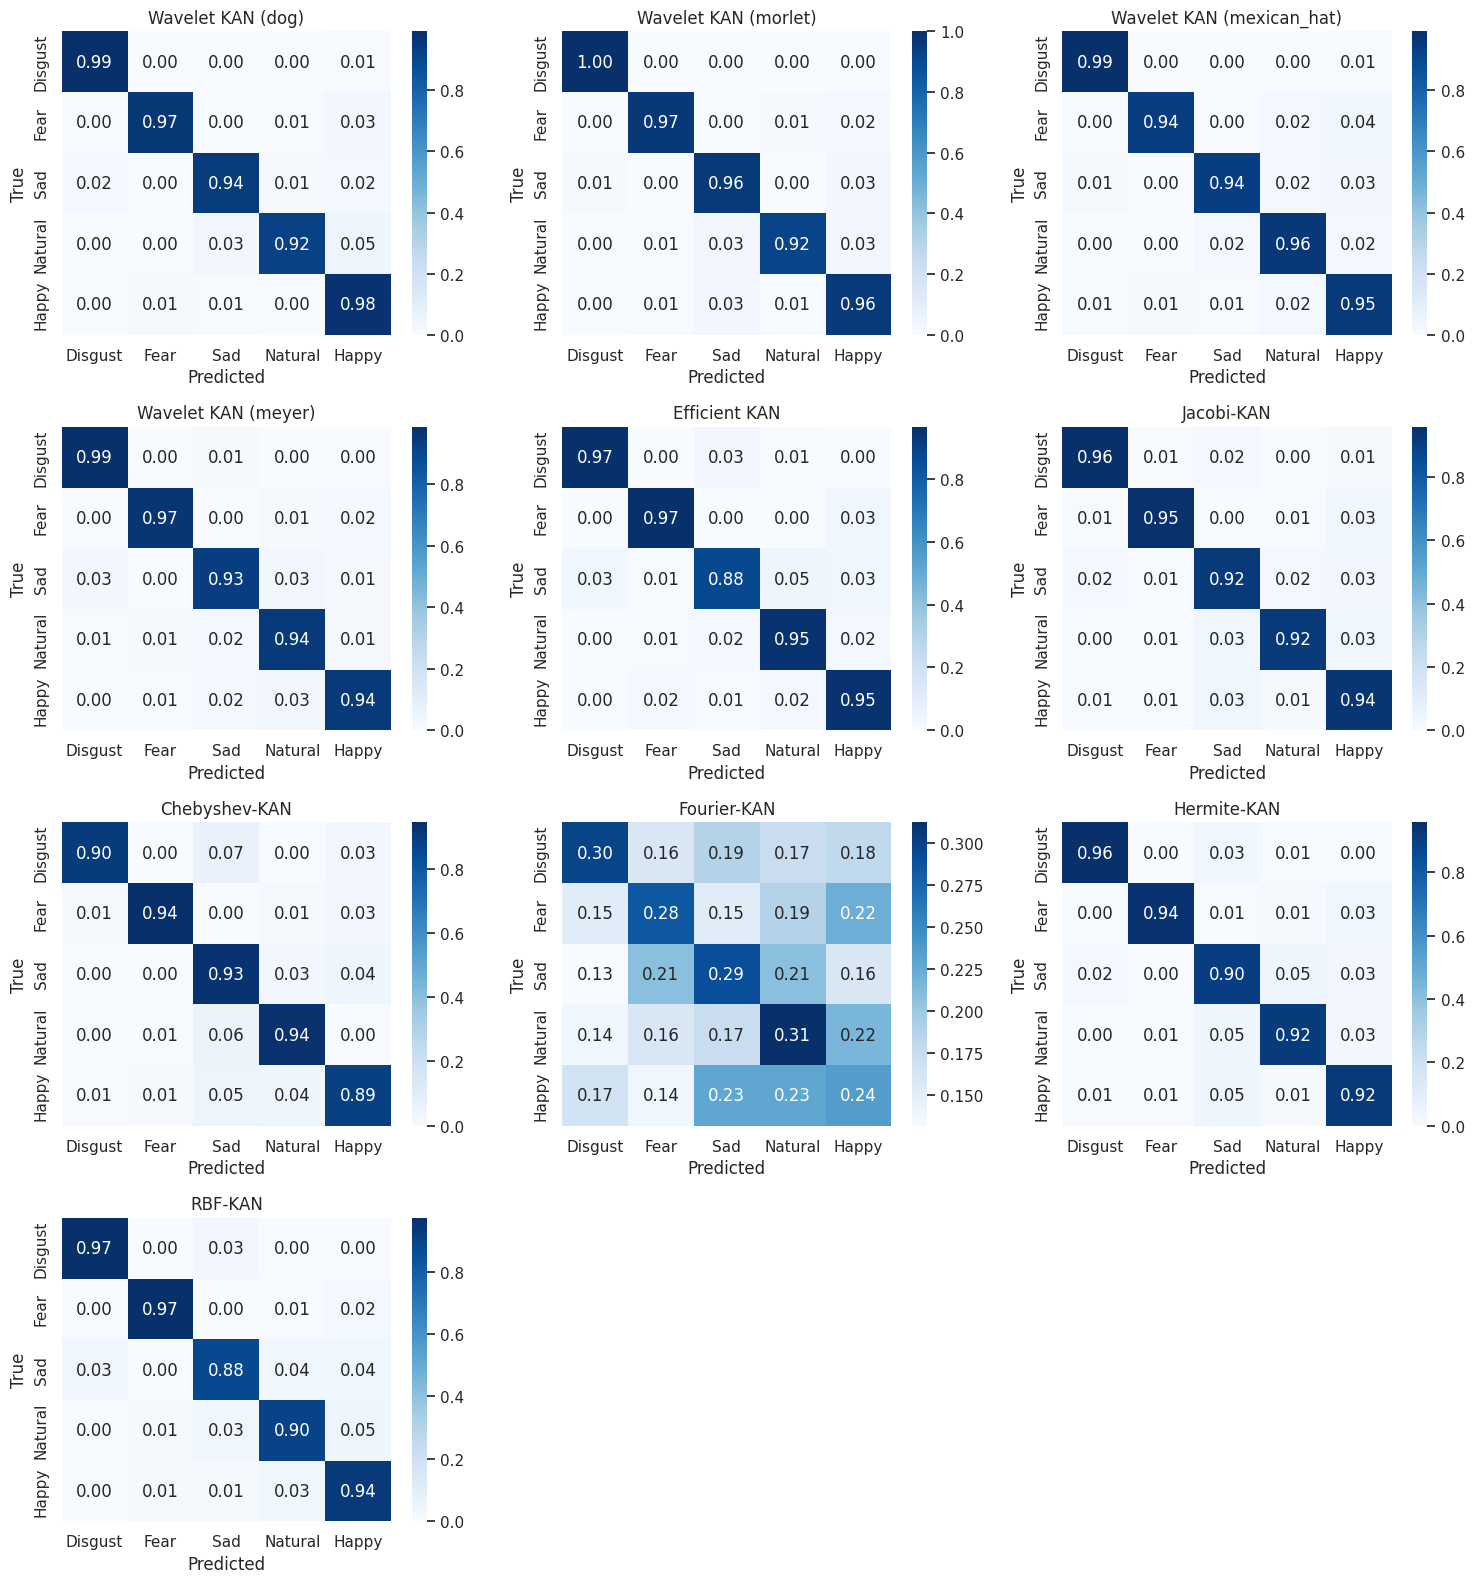

In [ ]:
# Example: Construct a dictionary of Confusion Matrices for each model
# assuming each metrics_dict["confusion_matrix"] is already populated
# (i.e., after running all folds, summing them up, etc.)
class_names = ["Disgust", "Fear", "Sad", "Natural", "Happy"]

all_cm = {
    "Wavelet KAN (dog)":          wavelet_kan_metrics["dog"]["confusion_matrix"],
    "Wavelet KAN (morlet)":       wavelet_kan_metrics["morlet"]["confusion_matrix"],
    "Wavelet KAN (mexican_hat)":  wavelet_kan_metrics["mexican_hat"]["confusion_matrix"],
    "Wavelet KAN (meyer)":        wavelet_kan_metrics["meyer"]["confusion_matrix"],
    # "Wavelet KAN (shannon)" is skipped/excluded
    "Efficient KAN":              efficient_kan_metrics["confusion_matrix"],
    "Jacobi-KAN":                 jacobi_kan_metrics["confusion_matrix"],
    "Chebyshev-KAN":              cheby_kan_metrics["confusion_matrix"],
    "Fourier-KAN":                fourier_kan_metrics["confusion_matrix"],
    "Hermite-KAN":                hermite_kan_metrics["confusion_matrix"],
    "RBF-KAN":                    rbf_kan_metrics["confusion_matrix"]
}

# Now you can pass all_cm to a multi-subplot plotting function:
plot_confusion_matrices(all_cm, class_names)


# Separated

In [ ]:
def plot_confusion_matrix_per_model(all_cm, class_names):
    """
    Plots a separate confusion matrix for each model in all_cm.

    Parameters:
    -----------
    all_cm : dict
        Dictionary of the form {model_name: confusion_matrix_ndarray, ...}.
    class_names : list or array-like
        List of class names for labeling the confusion matrix axes.
    """
    for model_name, cm in all_cm.items():
        # Normalize confusion matrix row-wise
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        plt.figure(figsize=(6, 4))  # Create a new figure for each model
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()  # Adjust layout so labels/titles fit nicely
        plt.show()

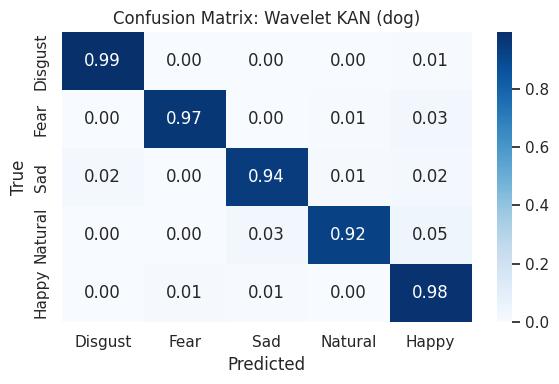

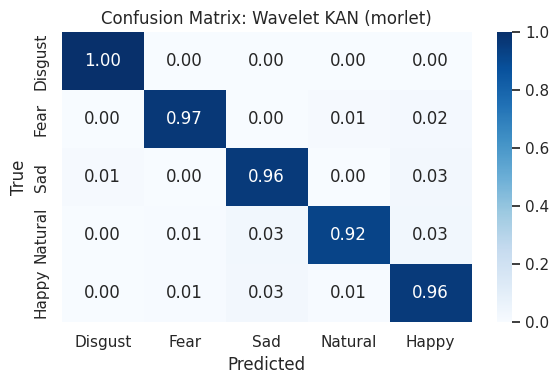

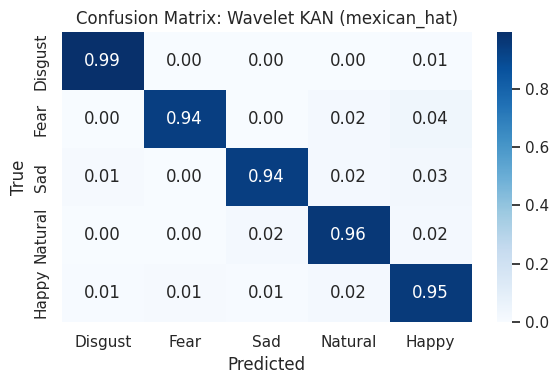

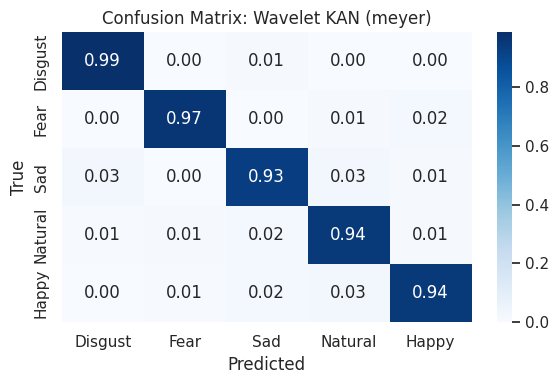

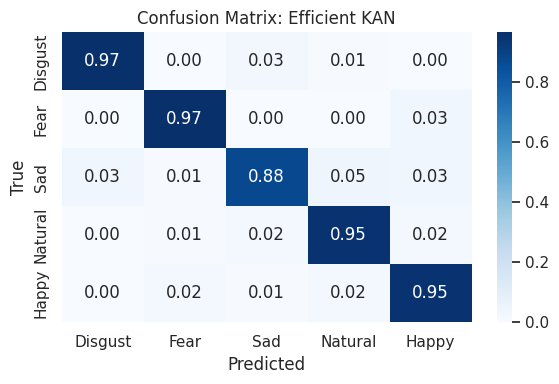

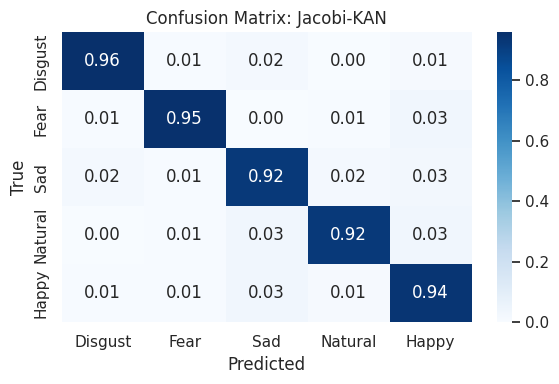

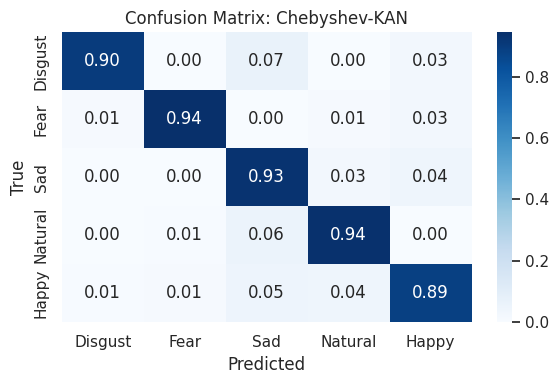

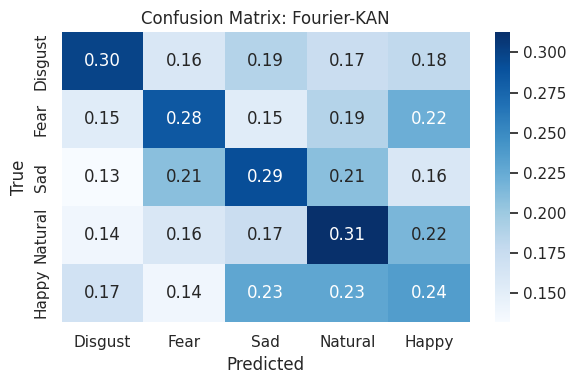

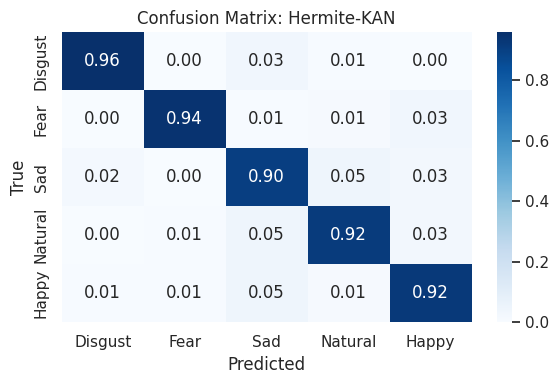

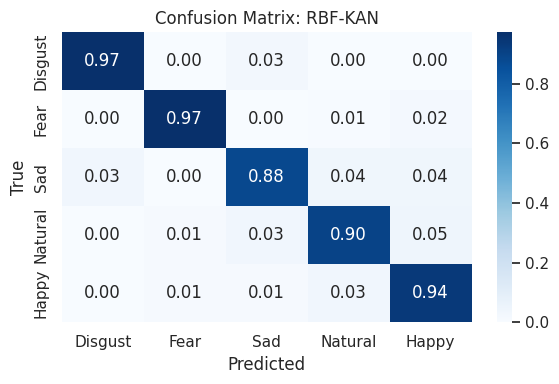

In [ ]:
plot_confusion_matrix_per_model(all_cm, class_names)

# Separate Branch

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EEG data shape: (720, 74, 310)
Eye data shape: (720, 74, 33)
Labels shape:   (720,)
Class names: ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
Number of classes: 5

Experiment 1: EEG-only Efficient KAN

[EEG-only] Fold 1/5
Epoch [1/100] | Train Loss: 23.9938 | Val Loss: 10.6810 | Train Acc: 0.3576 | Val Acc: 0.4514 | F1: 0.3877
Epoch [2/100] | Train Loss: 9.7940 | Val Loss: 6.4775 | Train Acc: 0.5035 | Val Acc: 0.5694 | F1: 0.5108


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100] | Train Loss: 3.4874 | Val Loss: 3.2464 | Train Acc: 0.6684 | Val Acc: 0.6667 | F1: 0.6565
Epoch [4/100] | Train Loss: 4.8707 | Val Loss: 1.5745 | Train Acc: 0.6337 | Val Acc: 0.7569 | F1: 0.7434
Epoch [5/100] | Train Loss: 3.0435 | Val Loss: 4.4803 | Train Acc: 0.6910 | Val Acc: 0.5347 | F1: 0.4823
Epoch [6/100] | Train Loss: 3.7411 | Val Loss: 2.5004 | Train Acc: 0.6788 | Val Acc: 0.6806 | F1: 0.6482
Epoch [7/100] | Train Loss: 3.2205 | Val Loss: 1.7584 | Train Acc: 0.6979 | Val Acc: 0.7639 | F1: 0.7636
Epoch [8/100] | Train Loss: 2.5186 | Val Loss: 2.5882 | Train Acc: 0.7326 | Val Acc: 0.7292 | F1: 0.7168
Epoch [9/100] | Train Loss: 2.1395 | Val Loss: 3.6463 | Train Acc: 0.7309 | Val Acc: 0.6319 | F1: 0.6220
Epoch [10/100] | Train Loss: 2.2367 | Val Loss: 2.9168 | Train Acc: 0.7396 | Val Acc: 0.6944 | F1: 0.6677
Epoch [11/100] | Train Loss: 1.6865 | Val Loss: 1.8944 | Train Acc: 0.7812 | Val Acc: 0.7361 | F1: 0.7273
Epoch [12/100] | Train Loss: 1.6956 | Val Loss: 2.072

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100] | Train Loss: 5.6420 | Val Loss: 1.4899 | Train Acc: 0.6875 | Val Acc: 0.7708 | F1: 0.7614
Epoch [10/100] | Train Loss: 2.5037 | Val Loss: 3.0079 | Train Acc: 0.7274 | Val Acc: 0.7361 | F1: 0.7250
Epoch [11/100] | Train Loss: 2.2122 | Val Loss: 2.0683 | Train Acc: 0.7500 | Val Acc: 0.7778 | F1: 0.7523
Epoch [12/100] | Train Loss: 2.3268 | Val Loss: 2.4222 | Train Acc: 0.7483 | Val Acc: 0.7431 | F1: 0.7533
Epoch [13/100] | Train Loss: 2.3722 | Val Loss: 1.8285 | Train Acc: 0.7378 | Val Acc: 0.8056 | F1: 0.8043
Epoch [14/100] | Train Loss: 1.6632 | Val Loss: 2.4826 | Train Acc: 0.7622 | Val Acc: 0.7569 | F1: 0.7571
Epoch [15/100] | Train Loss: 1.2289 | Val Loss: 0.9380 | Train Acc: 0.7986 | Val Acc: 0.8611 | F1: 0.8610
Epoch [16/100] | Train Loss: 1.7079 | Val Loss: 1.4468 | Train Acc: 0.7639 | Val Acc: 0.7639 | F1: 0.7688
Epoch [17/100] | Train Loss: 1.4151 | Val Loss: 2.4970 | Train Acc: 0.7830 | Val Acc: 0.7778 | F1: 0.7710
Epoch [18/100] | Train Loss: 2.4767 | Val Loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100] | Train Loss: 7.5367 | Val Loss: 4.4753 | Train Acc: 0.5868 | Val Acc: 0.5208 | F1: 0.4557
Epoch [4/100] | Train Loss: 3.2975 | Val Loss: 3.4667 | Train Acc: 0.6667 | Val Acc: 0.6389 | F1: 0.6309
Epoch [5/100] | Train Loss: 2.2209 | Val Loss: 2.2997 | Train Acc: 0.7292 | Val Acc: 0.7569 | F1: 0.7601
Epoch [6/100] | Train Loss: 2.2089 | Val Loss: 1.6099 | Train Acc: 0.7413 | Val Acc: 0.7569 | F1: 0.7597
Epoch [7/100] | Train Loss: 1.5010 | Val Loss: 1.0794 | Train Acc: 0.7517 | Val Acc: 0.7778 | F1: 0.7828
Epoch [8/100] | Train Loss: 1.4032 | Val Loss: 2.0602 | Train Acc: 0.7552 | Val Acc: 0.7708 | F1: 0.7658
Epoch [9/100] | Train Loss: 2.1519 | Val Loss: 3.8796 | Train Acc: 0.7396 | Val Acc: 0.6042 | F1: 0.6091
Epoch [10/100] | Train Loss: 3.3202 | Val Loss: 5.3956 | Train Acc: 0.6528 | Val Acc: 0.7014 | F1: 0.6373
Epoch [11/100] | Train Loss: 3.3708 | Val Loss: 2.4820 | Train Acc: 0.6667 | Val Acc: 0.7569 | F1: 0.7567
Epoch [12/100] | Train Loss: 2.0074 | Val Loss: 1.478

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [87/100] | Train Loss: 5.0986 | Val Loss: 20.7590 | Train Acc: 0.7309 | Val Acc: 0.5694 | F1: 0.5180
Epoch [88/100] | Train Loss: 7.5746 | Val Loss: 9.7803 | Train Acc: 0.7344 | Val Acc: 0.7014 | F1: 0.6930
Epoch [89/100] | Train Loss: 5.1279 | Val Loss: 3.5986 | Train Acc: 0.8003 | Val Acc: 0.7986 | F1: 0.8024
Epoch [90/100] | Train Loss: 2.5659 | Val Loss: 4.8761 | Train Acc: 0.8559 | Val Acc: 0.7708 | F1: 0.7613
Epoch [91/100] | Train Loss: 1.7465 | Val Loss: 3.1600 | Train Acc: 0.8472 | Val Acc: 0.7917 | F1: 0.7858
Epoch [92/100] | Train Loss: 1.9017 | Val Loss: 2.7012 | Train Acc: 0.8490 | Val Acc: 0.7986 | F1: 0.7858
Epoch [93/100] | Train Loss: 2.2697 | Val Loss: 2.0949 | Train Acc: 0.8229 | Val Acc: 0.7986 | F1: 0.7947
Epoch [94/100] | Train Loss: 1.1972 | Val Loss: 2.2554 | Train Acc: 0.8785 | Val Acc: 0.7778 | F1: 0.7819
Epoch [95/100] | Train Loss: 1.5282 | Val Loss: 4.3325 | Train Acc: 0.8524 | Val Acc: 0.7431 | F1: 0.7204
Epoch [96/100] | Train Loss: 3.1393 | Val Los

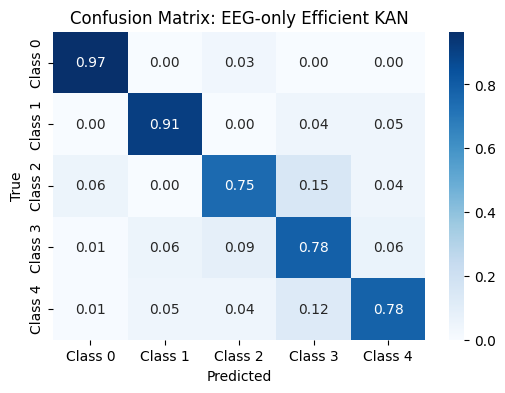


Experiment 2: Eye-only Efficient KAN

[Eye-only] Fold 1/5
Epoch [1/100] | Train Loss: 2.2305 | Val Loss: 1.0617 | Train Acc: 0.4167 | Val Acc: 0.5972 | F1: 0.5484
Epoch [2/100] | Train Loss: 0.7900 | Val Loss: 0.8653 | Train Acc: 0.7118 | Val Acc: 0.7153 | F1: 0.6679
Epoch [3/100] | Train Loss: 0.6689 | Val Loss: 0.6532 | Train Acc: 0.7622 | Val Acc: 0.7083 | F1: 0.7026
Epoch [4/100] | Train Loss: 0.5340 | Val Loss: 0.4518 | Train Acc: 0.8021 | Val Acc: 0.8333 | F1: 0.8184
Epoch [5/100] | Train Loss: 0.4737 | Val Loss: 0.5473 | Train Acc: 0.8299 | Val Acc: 0.8333 | F1: 0.8362
Epoch [6/100] | Train Loss: 0.4926 | Val Loss: 0.4473 | Train Acc: 0.8316 | Val Acc: 0.8333 | F1: 0.8322
Epoch [7/100] | Train Loss: 0.4254 | Val Loss: 0.6246 | Train Acc: 0.8542 | Val Acc: 0.8403 | F1: 0.8391
Epoch [8/100] | Train Loss: 0.2959 | Val Loss: 0.3754 | Train Acc: 0.8924 | Val Acc: 0.8889 | F1: 0.8867
Epoch [9/100] | Train Loss: 0.3428 | Val Loss: 0.7159 | Train Acc: 0.8872 | Val Acc: 0.7917 | F1: 0.7

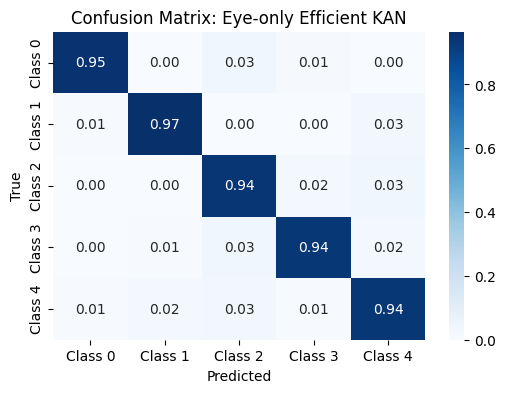


Experiment 3: Multimodal (Fusion) Efficient KAN

[Multimodal] Fold 1/5
Epoch [1/100] | Train Loss: 15.8944 | Val Loss: 9.3017 | Train Acc: 0.3108 | Val Acc: 0.3611 | F1: 0.3075
Epoch [2/100] | Train Loss: 4.9124 | Val Loss: 3.1320 | Train Acc: 0.4549 | Val Acc: 0.4931 | F1: 0.4444
Epoch [3/100] | Train Loss: 3.6719 | Val Loss: 1.4122 | Train Acc: 0.5104 | Val Acc: 0.7014 | F1: 0.7061
Epoch [4/100] | Train Loss: 1.7248 | Val Loss: 1.7128 | Train Acc: 0.6962 | Val Acc: 0.6458 | F1: 0.6242
Epoch [5/100] | Train Loss: 1.8087 | Val Loss: 2.3138 | Train Acc: 0.7135 | Val Acc: 0.6458 | F1: 0.6288
Epoch [6/100] | Train Loss: 1.4886 | Val Loss: 1.4084 | Train Acc: 0.7344 | Val Acc: 0.7292 | F1: 0.7248
Epoch [7/100] | Train Loss: 1.3198 | Val Loss: 2.4067 | Train Acc: 0.7743 | Val Acc: 0.7014 | F1: 0.7020
Epoch [8/100] | Train Loss: 1.0742 | Val Loss: 0.7954 | Train Acc: 0.7899 | Val Acc: 0.7847 | F1: 0.7773
Epoch [9/100] | Train Loss: 0.8064 | Val Loss: 0.4552 | Train Acc: 0.8455 | Val Acc: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100] | Train Loss: 3.0618 | Val Loss: 4.2536 | Train Acc: 0.5660 | Val Acc: 0.5764 | F1: 0.5133
Epoch [4/100] | Train Loss: 2.8453 | Val Loss: 4.3289 | Train Acc: 0.6042 | Val Acc: 0.5764 | F1: 0.5361
Epoch [5/100] | Train Loss: 2.4773 | Val Loss: 2.3237 | Train Acc: 0.6771 | Val Acc: 0.6806 | F1: 0.6712
Epoch [6/100] | Train Loss: 1.3077 | Val Loss: 1.8741 | Train Acc: 0.7326 | Val Acc: 0.7014 | F1: 0.6909
Epoch [7/100] | Train Loss: 1.0551 | Val Loss: 0.9635 | Train Acc: 0.7882 | Val Acc: 0.7847 | F1: 0.7852
Epoch [8/100] | Train Loss: 1.0606 | Val Loss: 0.8371 | Train Acc: 0.7604 | Val Acc: 0.8056 | F1: 0.8064
Epoch [9/100] | Train Loss: 1.7936 | Val Loss: 2.2006 | Train Acc: 0.7431 | Val Acc: 0.7083 | F1: 0.6862
Epoch [10/100] | Train Loss: 1.8191 | Val Loss: 2.4060 | Train Acc: 0.7656 | Val Acc: 0.8056 | F1: 0.7898
Epoch [11/100] | Train Loss: 1.7398 | Val Loss: 2.3508 | Train Acc: 0.8108 | Val Acc: 0.7569 | F1: 0.7423
Epoch [12/100] | Train Loss: 1.0100 | Val Loss: 0.868

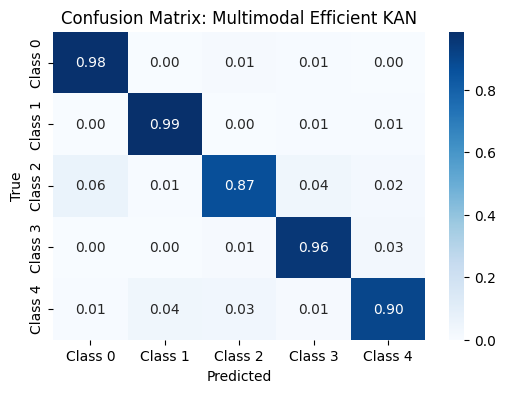


=== Final Results Comparison ===
     Model  Accuracy  Precision   Recall       F1      AUC  NumParams
  EEG-only  0.837500   0.855802 0.837537 0.836206 0.964586    8810880
  Eye-only  0.947222   0.949533 0.947389 0.947424 0.992107     939648
Multimodal  0.938889   0.941094 0.939113 0.938606 0.985702    9797760


In [ ]:
import numpy as np
import pickle
import os
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import MinMaxScaler, label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------
# Device, Seeding, and Globals
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

torch.manual_seed(42)
np.random.seed(42)

global_params = {
    "k_folds": 5,
    "batch_size": 16,
    "num_epochs": 100,
    "hidden_dim": 64,
    "grid_size": 5,
    "learning_rate": 1e-3,
    # other parameters (e.g. wavelet_types) are not used in this integration
}

# ---------------------------
# Mount drive if in Colab (optional)
# ---------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print("Not in Colab or drive mount not needed.")

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------
eeg_file_dir = '/content/drive/MyDrive/EEG_DE_features/'
eye_movement_file_dir = '/content/drive/MyDrive/Eye_movement_features/'

def pad_data(data, target_shape):
    pad_width = [
        (0, target_shape[i] - data.shape[i]) if i < len(data.shape)
        else (0, target_shape[i]) for i in range(len(target_shape))
    ]
    return np.pad(data, pad_width, mode='constant')

all_data = []
all_eye_data = []
all_labels = []
subjects = []

# Loop over subjects (adjust the range if needed)
for i in range(1, 17):
    eeg_file_path = os.path.join(eeg_file_dir, f'{i}_123.npz')
    eye_file_path = os.path.join(eye_movement_file_dir, f'{i}_123.npz')

    eeg_npz = np.load(eeg_file_path, allow_pickle=True)
    eeg_data = pickle.loads(eeg_npz['data'])
    eeg_label = pickle.loads(eeg_npz['label'])

    eye_npz = np.load(eye_file_path, allow_pickle=True)
    eye_data = pickle.loads(eye_npz['data'])

    for key in eeg_data.keys():
        all_data.append(eeg_data[key])
        all_eye_data.append(eye_data[key])
        all_labels.append(eeg_label[key][0])
        subjects.append(i)

# Determine maximum shapes and pad each sample
max_eeg_shape = np.max([d.shape for d in all_data], axis=0)
max_eye_shape = np.max([d.shape for d in all_eye_data], axis=0)

all_data_padded     = [pad_data(d, max_eeg_shape) for d in all_data]
all_eye_data_padded = [pad_data(d, max_eye_shape) for d in all_eye_data]

eeg_data_array = np.array(all_data_padded)
eye_data_array = np.array(all_eye_data_padded)
labels_array   = np.array(all_labels)

print("EEG data shape:", eeg_data_array.shape)
print("Eye data shape:", eye_data_array.shape)
print("Labels shape:  ", labels_array.shape)

# Flatten the data (each sample becomes a vector)
eeg_data_flat = eeg_data_array.reshape(eeg_data_array.shape[0], -1)
eye_data_flat = eye_data_array.reshape(eye_data_array.shape[0], -1)

# Scale features
scaler_eeg = MinMaxScaler()
scaler_eye = MinMaxScaler()

eeg_data_flat = scaler_eeg.fit_transform(eeg_data_flat)
eye_data_flat = scaler_eye.fit_transform(eye_data_flat)

labels_array = labels_array.astype(int)
num_classes = len(np.unique(labels_array))
class_names = [f"Class {i}" for i in range(num_classes)]
print("Class names:", class_names)
print("Number of classes:", num_classes)

# ---------------------------
# Utility Functions
# ---------------------------
def compute_average_metrics(metrics_dict):
    avg = {}
    avg['accuracy']   = np.mean(metrics_dict['accuracy'])
    avg['precision']  = np.mean(metrics_dict['precision'])
    avg['recall']     = np.mean(metrics_dict['recall'])
    avg['f1']         = np.mean(metrics_dict['f1'])
    avg['auc']        = np.nanmean(metrics_dict['auc'])
    avg['confusion_matrix'] = metrics_dict['confusion_matrix']
    avg['num_parameters']   = metrics_dict['num_parameters']
    return avg

def plot_confusion_matrix(cm, classes, model_name="Model"):
    plt.figure(figsize=(6,4))
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# ---------------------------
# Training Functions
# ---------------------------
def train_and_evaluate_single(model, train_loader, test_loader, epochs, lr, device, metrics_dict, n_classes):
    """
    Training and evaluation for models with a single input (EEG-only or Eye-only).
    """
    if metrics_dict['num_parameters'] is None:
        metrics_dict['num_parameters'] = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_accuracy = 0.0
    best_metrics  = None

    train_losses = []
    val_losses   = []

    for ep in range(epochs):
        # ----- Training -----
        model.train()
        total_loss = 0.0
        total_correct = 0

        for inputs, labels in train_loader:
            inputs  = inputs.to(device)
            labels  = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss    += loss.item() * labels.size(0)
            _, predicted   = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()

        epoch_train_loss = total_loss / len(train_loader.dataset)
        epoch_train_acc  = total_correct / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- Validation -----
        model.eval()
        val_total_loss = 0.0
        val_correct    = 0
        all_labels     = []
        all_preds      = []
        all_probs      = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs  = inputs.to(device)
                labels  = labels.to(device)

                outputs = model(inputs)
                loss    = criterion(outputs, labels)
                val_total_loss += loss.item() * labels.size(0)

                _, predicted = torch.max(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_total_loss / len(test_loader.dataset)
        epoch_val_acc  = val_correct / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Compute additional metrics
        f1_val   = f1_score(all_labels, all_preds, average='macro')
        prec_val = precision_score(all_labels, all_preds, average='macro')
        rec_val  = recall_score(all_labels, all_preds, average='macro')
        labels_bin = label_binarize(all_labels, classes=range(n_classes))
        try:
            auc_val = roc_auc_score(labels_bin, np.array(all_probs),
                                    average='macro', multi_class='ovr')
        except ValueError:
            auc_val = float('nan')
        cm = confusion_matrix(all_labels, all_preds)

        if epoch_val_acc > best_accuracy:
            best_accuracy = epoch_val_acc
            best_metrics  = {
                'accuracy':   best_accuracy,
                'precision':  prec_val,
                'recall':     rec_val,
                'f1':         f1_val,
                'auc':        auc_val,
                'confusion_matrix': cm
            }

        print(f"Epoch [{ep+1}/{epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | "
              f"Val Acc: {epoch_val_acc:.4f} | "
              f"F1: {f1_val:.4f}")

    # Save best metrics
    metrics_dict['accuracy'].append(best_metrics['accuracy'])
    metrics_dict['precision'].append(best_metrics['precision'])
    metrics_dict['recall'].append(best_metrics['recall'])
    metrics_dict['f1'].append(best_metrics['f1'])
    metrics_dict['auc'].append(best_metrics['auc'])
    metrics_dict['confusion_matrix'] += best_metrics['confusion_matrix']

    return train_losses, val_losses

def train_and_evaluate_with_losses(model, train_loader, test_loader, epochs, lr, device, metrics_dict, n_classes):
    """
    Training and evaluation for models with two inputs (multimodal: EEG and Eye).
    """
    if metrics_dict['num_parameters'] is None:
        metrics_dict['num_parameters'] = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_accuracy = 0.0
    best_metrics  = None

    train_losses = []
    val_losses   = []

    for ep in range(epochs):
        # --------------------- TRAINING ---------------------
        model.train()
        total_loss = 0.0
        total_correct = 0

        for eeg_batch, eye_batch, labels_batch in train_loader:
            eeg_batch    = eeg_batch.to(device)
            eye_batch    = eye_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(eeg_batch, eye_batch)
            loss    = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss    += loss.item() * labels_batch.size(0)
            _, predicted   = torch.max(outputs, dim=1)
            total_correct += (predicted == labels_batch).sum().item()

        epoch_train_loss = total_loss / len(train_loader.dataset)
        epoch_train_acc  = total_correct / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ------------------- VALIDATION ---------------------
        model.eval()
        val_total_loss = 0.0
        val_correct    = 0
        all_labels     = []
        all_preds      = []
        all_probs      = []

        with torch.no_grad():
            for eeg_val, eye_val, labels_val in test_loader:
                eeg_val    = eeg_val.to(device)
                eye_val    = eye_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(eeg_val, eye_val)
                val_loss    = criterion(outputs_val, labels_val)
                val_total_loss += val_loss.item() * labels_val.size(0)

                _, val_pred   = torch.max(outputs_val, dim=1)
                val_correct  += (val_pred == labels_val).sum().item()

                all_labels.extend(labels_val.cpu().numpy())
                all_preds.extend(val_pred.cpu().numpy())
                probs = torch.softmax(outputs_val, dim=1)
                all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_total_loss / len(test_loader.dataset)
        epoch_val_acc  = val_correct / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Compute additional metrics
        f1_val   = f1_score(all_labels, all_preds, average='macro')
        prec_val = precision_score(all_labels, all_preds, average='macro')
        rec_val  = recall_score(all_labels, all_preds, average='macro')

        labels_bin = label_binarize(all_labels, classes=range(n_classes))
        try:
            auc_val = roc_auc_score(labels_bin, np.array(all_probs),
                                    average='macro', multi_class='ovr')
        except ValueError:
            auc_val = float('nan')

        cm = confusion_matrix(all_labels, all_preds)

        if epoch_val_acc > best_accuracy:
            best_accuracy = epoch_val_acc
            best_metrics  = {
                'accuracy':   best_accuracy,
                'precision':  prec_val,
                'recall':     rec_val,
                'f1':         f1_val,
                'auc':        auc_val,
                'confusion_matrix': cm
            }

        print(f"Epoch [{ep+1}/{epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | "
              f"Val Acc: {epoch_val_acc:.4f} | "
              f"F1: {f1_val:.4f}")

    # Save best metrics
    metrics_dict['accuracy'].append(best_metrics['accuracy'])
    metrics_dict['precision'].append(best_metrics['precision'])
    metrics_dict['recall'].append(best_metrics['recall'])
    metrics_dict['f1'].append(best_metrics['f1'])
    metrics_dict['auc'].append(best_metrics['auc'])
    metrics_dict['confusion_matrix'] += best_metrics['confusion_matrix']

    return train_losses, val_losses

# ---------------------------
# Model Definitions
# ---------------------------
class eKANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5):
        super().__init__()
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size))
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.spline_weight, a=math.sqrt(5))

    def forward(self, x):
        base_out   = F.linear(F.silu(x), self.base_weight)
        spline_val = torch.sum(self.spline_weight, dim=-1)
        spline_out = F.linear(x, spline_val)
        return base_out + spline_out

class eKAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=5):
        super().__init__()
        self.layers = nn.ModuleList([
            eKANLinear(in_f, out_f, grid_size)
            for in_f, out_f in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# EEG-only Efficient KAN: a single-branch model.
class EEG_EfficientKAN(nn.Module):
    def __init__(self, eeg_dim, hidden_dim, num_classes, grid_size=5):
        super().__init__()
        # A simple 2-layer eKAN that maps from eeg_dim -> hidden_dim -> num_classes.
        self.model = eKAN([eeg_dim, hidden_dim, num_classes], grid_size)

    def forward(self, x):
        return self.model(x)

# Eye-only Efficient KAN: a single-branch model.
class Eye_EfficientKAN(nn.Module):
    def __init__(self, eye_dim, hidden_dim, num_classes, grid_size=5):
        super().__init__()
        self.model = eKAN([eye_dim, hidden_dim, num_classes], grid_size)

    def forward(self, x):
        return self.model(x)

# Multimodal Efficient KAN: separate branches with fusion.
class CustomEfficientKAN(nn.Module):
    def __init__(self, eeg_dim, eye_dim, hidden_dim, num_classes, grid_size=5):
        super().__init__()
        self.eeg_branch = eKAN([eeg_dim, hidden_dim], grid_size)
        self.eye_branch = eKAN([eye_dim, hidden_dim], grid_size)
        self.fusion     = eKAN([2*hidden_dim, hidden_dim, num_classes], grid_size)

    def forward(self, eeg_in, eye_in):
        x_eeg = self.eeg_branch(eeg_in)
        x_eye = self.eye_branch(eye_in)
        combined = torch.cat((x_eeg, x_eye), dim=1)
        return self.fusion(combined)

# ---------------------------
# Experiment 1: EEG-only Efficient KAN
# ---------------------------
print("\n====================")
print("Experiment 1: EEG-only Efficient KAN")
print("====================")

eeg_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

skf = StratifiedKFold(n_splits=global_params["k_folds"], shuffle=True, random_state=42)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[EEG-only] Fold {fold_idx+1}/{global_params['k_folds']}")

    # Prepare training and test splits (EEG-only)
    X_train = eeg_data_flat[train_idx]
    X_test  = eeg_data_flat[test_idx]
    y_train = labels_array[train_idx]
    y_test  = labels_array[test_idx]

    # Convert to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds  = TensorDataset(X_test_t, y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=global_params["batch_size"], shuffle=False)

    # Initialize EEG-only model
    eeg_model = EEG_EfficientKAN(
        eeg_dim    = X_train_t.shape[1],
        hidden_dim = global_params["hidden_dim"],
        num_classes= num_classes,
        grid_size  = global_params["grid_size"]
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_single(
        model        = eeg_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = eeg_metrics,
        n_classes    = num_classes
    )

avg_eeg = compute_average_metrics(eeg_metrics)
print("\nEEG-only Efficient KAN (Average CV) Metrics:")
for k, v in avg_eeg.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_eeg['confusion_matrix'], class_names, "EEG-only Efficient KAN")

# ---------------------------
# Experiment 2: Eye-only Efficient KAN
# ---------------------------
print("\n====================")
print("Experiment 2: Eye-only Efficient KAN")
print("====================")

eye_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eye_data_flat, labels_array)):
    print(f"\n[Eye-only] Fold {fold_idx+1}/{global_params['k_folds']}")

    # Prepare training and test splits (Eye-only)
    X_train = eye_data_flat[train_idx]
    X_test  = eye_data_flat[test_idx]
    y_train = labels_array[train_idx]
    y_test  = labels_array[test_idx]

    # Convert to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds  = TensorDataset(X_test_t, y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=global_params["batch_size"], shuffle=False)

    # Initialize Eye-only model
    eye_model = Eye_EfficientKAN(
        eye_dim    = X_train_t.shape[1],
        hidden_dim = global_params["hidden_dim"],
        num_classes= num_classes,
        grid_size  = global_params["grid_size"]
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_single(
        model        = eye_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = eye_metrics,
        n_classes    = num_classes
    )

avg_eye = compute_average_metrics(eye_metrics)
print("\nEye-only Efficient KAN (Average CV) Metrics:")
for k, v in avg_eye.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_eye['confusion_matrix'], class_names, "Eye-only Efficient KAN")

# ---------------------------
# Experiment 3: Multimodal (Fusion) Efficient KAN
# ---------------------------
print("\n====================")
print("Experiment 3: Multimodal (Fusion) Efficient KAN")
print("====================")

multimodal_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int),
    'num_parameters': None
}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(eeg_data_flat, labels_array)):
    print(f"\n[Multimodal] Fold {fold_idx+1}/{global_params['k_folds']}")

    # For multimodal, use both EEG and Eye features.
    X_train_eeg = eeg_data_flat[train_idx]
    X_test_eeg  = eeg_data_flat[test_idx]
    X_train_eye = eye_data_flat[train_idx]
    X_test_eye  = eye_data_flat[test_idx]
    y_train     = labels_array[train_idx]
    y_test      = labels_array[test_idx]

    # Convert to torch tensors
    X_train_eeg_t = torch.tensor(X_train_eeg, dtype=torch.float32)
    X_test_eeg_t  = torch.tensor(X_test_eeg, dtype=torch.float32)
    X_train_eye_t = torch.tensor(X_train_eye, dtype=torch.float32)
    X_test_eye_t  = torch.tensor(X_test_eye, dtype=torch.float32)
    y_train_t     = torch.tensor(y_train, dtype=torch.long)
    y_test_t      = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_eeg_t, X_train_eye_t, y_train_t)
    test_ds  = TensorDataset(X_test_eeg_t, X_test_eye_t, y_test_t)
    train_loader = DataLoader(train_ds, batch_size=global_params["batch_size"], shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=global_params["batch_size"], shuffle=False)

    # Initialize multimodal model
    multimodal_model = CustomEfficientKAN(
        eeg_dim    = X_train_eeg_t.shape[1],
        eye_dim    = X_train_eye_t.shape[1],
        hidden_dim = global_params["hidden_dim"],
        num_classes= num_classes,
        grid_size  = global_params["grid_size"]
    ).to(device)

    train_losses_fold, val_losses_fold = train_and_evaluate_with_losses(
        model        = multimodal_model,
        train_loader = train_loader,
        test_loader  = test_loader,
        epochs       = global_params["num_epochs"],
        lr           = global_params["learning_rate"],
        device       = device,
        metrics_dict = multimodal_metrics,
        n_classes    = num_classes
    )

avg_multimodal = compute_average_metrics(multimodal_metrics)
print("\nMultimodal Efficient KAN (Average CV) Metrics:")
for k, v in avg_multimodal.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v}")

plot_confusion_matrix(avg_multimodal['confusion_matrix'], class_names, "Multimodal Efficient KAN")

# ---------------------------
# Final Results Comparison
# ---------------------------
results_data = {
    "Model":      [],
    "Accuracy":   [],
    "Precision":  [],
    "Recall":     [],
    "F1":         [],
    "AUC":        [],
    "NumParams":  []
}

results_data["Model"].append("EEG-only")
results_data["Accuracy"].append(avg_eeg["accuracy"])
results_data["Precision"].append(avg_eeg["precision"])
results_data["Recall"].append(avg_eeg["recall"])
results_data["F1"].append(avg_eeg["f1"])
results_data["AUC"].append(avg_eeg["auc"])
results_data["NumParams"].append(avg_eeg["num_parameters"])

results_data["Model"].append("Eye-only")
results_data["Accuracy"].append(avg_eye["accuracy"])
results_data["Precision"].append(avg_eye["precision"])
results_data["Recall"].append(avg_eye["recall"])
results_data["F1"].append(avg_eye["f1"])
results_data["AUC"].append(avg_eye["auc"])
results_data["NumParams"].append(avg_eye["num_parameters"])

results_data["Model"].append("Multimodal")
results_data["Accuracy"].append(avg_multimodal["accuracy"])
results_data["Precision"].append(avg_multimodal["precision"])
results_data["Recall"].append(avg_multimodal["recall"])
results_data["F1"].append(avg_multimodal["f1"])
results_data["AUC"].append(avg_multimodal["auc"])
results_data["NumParams"].append(avg_multimodal["num_parameters"])

results_df = pd.DataFrame(results_data)
print("\n=== Final Results Comparison ===")
print(results_df.to_string(index=False))